# Исследование рынка заведений общественного питания Москвы

**Целью** работы является исследование рынка заведений общественного питания Москвы для определения параметров нового ресторана - вида заведения, количества посадочных мест, района расположения.

Работа разделена на следующие части:

#### Часть 1. Изучение и подготовка данных к анализу 
* [1.1 Изучение файлов с данными, получение общей информации, загрузка библиотек](#section1-1)
* [1.2 Предобработка данных](#section1-2)
#### Часть 2. Анализ данных
* [2.1 Соотношение видов объектов общественного питания](#section2-1)
* [2.2 Соотношение сетевых и несетевых заведений](#section2-2)
* [2.3 Сетевое распространение различных видов объектов общественного питания](#section2-3)
* [2.4 Связь количества посадочных мест с количеством заведений](#section2-4)
* [2.5 Среднее количество посадочных мест для различных видов объектов общественного питания](#section2-5)
* [2.6 Топ-10 улиц Москвы по количеству объектов общественного питания, районы их расположения](#section2-6)
#### Часть 3. Вывод

## Часть 1. Изучение и подготовка данных к анализу

<a id='section1-1'></a>
### 1.1 Изучение файлов с данными, получение общей информации, загрузка библиотек

In [1]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
filename = os.path.join(os.sep, os.getcwd(), 'datasets', 'rest_data.csv')
rest = pd.read_csv(filename)

Для получения общих сведений о датасете создадим функцию data_info():

In [3]:
def data_info(df):
    display(df.head(), df.info())
    print('Количество дубликатов:', df.duplicated().sum(), '\n')
    print('Количество пропусков:', df[df.isna()].count())
    return

In [4]:
data_info(rest)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


None

Количество дубликатов: 0 

Количество пропусков: id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64


<a id='section1-2'></a>
### 1.2 Предобработка данных

Сначала приведем все наименования заведений к нижнему регистру.

In [5]:
rest['object_name'] = rest['object_name'].str.lower()

При поиске неявных дубликатов подробно рассмотрим сетевые заведения, так как несетевые заведения, как правило, располагаются в городе в одном экземпляре.

Посчитаем количество уникальных названий сетевых заведений.

In [6]:
print('Уникальных названий сетевых заведений до обработки неявных дубликатов:', 
      rest.query('chain == "да"')['object_name'].nunique())

Уникальных названий сетевых заведений до обработки неявных дубликатов: 577


Видим много заведения, для которых в столбце "object_name" помимо названия, указан еще и тип заведения. Например, неявными дубликатами становятся 'кафе «папа джонс»' и 'пиццерия «папа джонс»', хотя сеть одна. Для того, чтобы вытащить только само название сети в кавычках создадим функцию extract_name и применим ее к сетевым заведениям:

In [7]:
words = ['кафе','ресторан', 'столовая', 'закусочная', 'кафетерий', 'кофейня', 'бар', 'пиццерия', 
         'магазин готовой еды', 'предприятие быстрого обслуживания', 'пбо', 'ресторан быстрого питания', 'паб']

def get_name(full_name):
    string = full_name
    for object_type in words:
        if object_type in full_name:
            string =  string.replace(object_type, '').replace('«', '').replace('»', '').strip()
        else:
            string = string
    return string
            
rest['object_name'] = rest['object_name'].apply(get_name)

Теперь обработаем такие неявные дубликаты, как "subway" и "сабвей". В данном случае обработка будет проводиться вручную, то есть только для самых популярных сетевых заведений.

In [8]:
def change_object_name(name):
    string = name
    if 'subway' in string:
        string = 'subway'
    elif 'сабвей' in string:
        string = 'subway'
    elif 'kfc' in string:
        string = 'kfc'
    elif 'чайхона №1' in string:
        string = 'чайхона №1'
    elif ('иль' in string) and ('патио' in string):
        string = 'il-patio'
    elif ('il' in string) and ('patio' in string):
        string = 'il-patio'
    elif 'starbucks' in string:
        string = 'starbucks'
    elif 'старбакс' in string:
        string = 'starbucks'
    elif 'коста кофе' in string:
        string = 'costa coffee'
    elif 'costa coffee' in string:
        string = 'costa coffee'
    elif 'мята lounge' in string:
        string = 'мята lounge'
    elif 'шоколадница' in string:
        string = 'шоколадница'
    elif 'икеа' in string:
        string = 'ikea'
    elif 'ikea' in string:
        string = 'ikea' 
    elif 'макдоналдс' in string:
        string = 'макдоналдс'    
    elif 'mcdonalds' in string:
        string = 'макдоналдс' 
    elif ('домино' in string) and ('пицца' in string):
        string = 'domino`s pizza'    
    elif ('domino' in string) and ('pizza' in string):
        string = 'domino`s pizza'  
    elif 'ванвок' in string:
        string = 'vanwok'  
    elif 'vanwok' in string:
        string = 'vanwok'
    elif 'van wok' in string:
        string = 'vanwok'
    else: 
        string = string
    return string

rest['object_name'] = rest['object_name'].apply(change_object_name)

Посмотрим количество уникальных названий заведений после обработки.

In [9]:
print('Уникальных названий сетевых заведений после обработки неявных дубликатов:', 
          rest.query('chain == "да"')['object_name'].nunique())

Уникальных названий сетевых заведений после обработки неявных дубликатов: 391


Проверим типы данных в таблице.

In [10]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


С типами данных все в порядке. Теоретически, можно было бы столбец "chain" сделать булевым типом. Однако, в данном случае в этом нет необходимости, потому что не составляет сложностей обратиться к сетевым заведениям через .query('chain == "да"').

Также проведем проверку на неявные дубликаты без столбца id.

In [11]:
rest[rest.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number'], keep='first')].count()

id             86
object_name    86
chain          86
object_type    86
address        86
number         86
dtype: int64

In [12]:
rest = (rest.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number'], keep='first')
           .reset_index(drop=True))

## Часть 2. Анализ данных

<a id='section2-1'></a>
### 2.1 Соотношение видов объектов общественного питания

Подготовим таблицу для анализа:

In [13]:
rest_object_types = (rest.groupby('object_type')
                         .agg({'id':'count'})
                         .sort_values(by='id', ascending=False)
                         .rename(columns={'id':'amount'})
                         .reset_index())

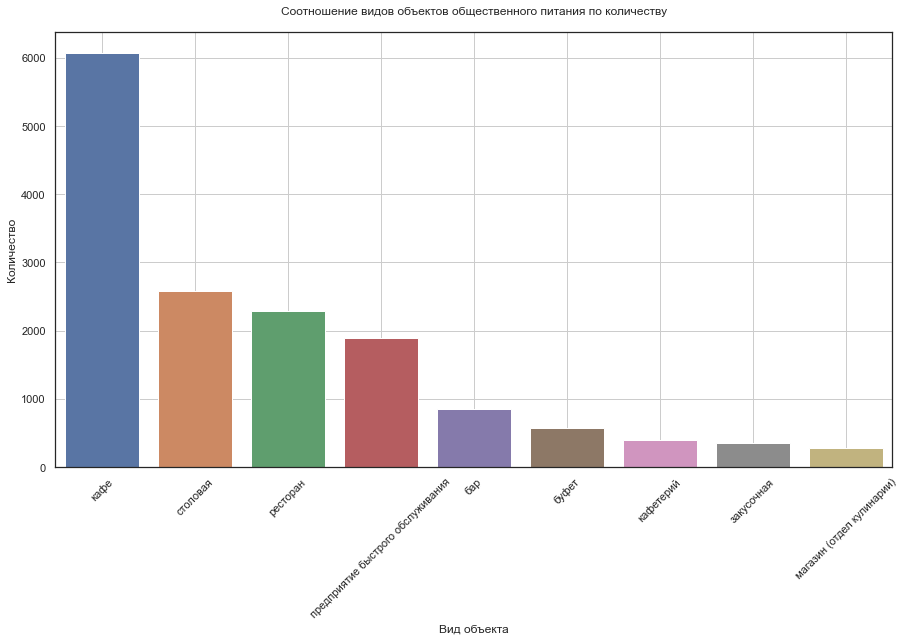

In [14]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style('white')

sns.barplot(data=rest_object_types, x='object_type', y='amount')

plt.grid()
plt.title('Соотношение видов объектов общественного питания по количеству'+ "\n")
plt.xlabel('Вид объекта')
plt.ylabel('Количество')
plt.xticks(rotation=45);

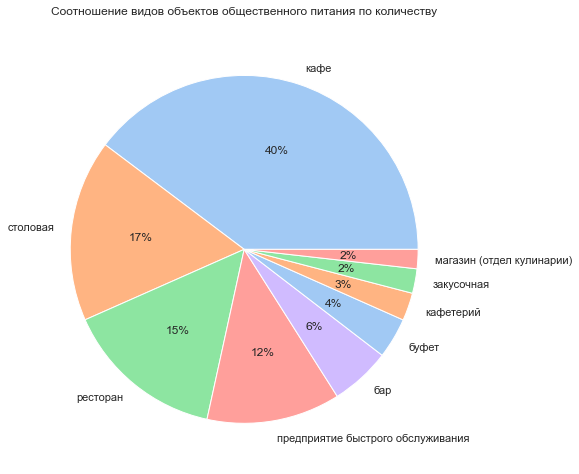

In [15]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(data=rest_object_types, labels='object_type', x='amount', colors = colors, autopct='%.0f%%')
plt.title('Соотношение видов объектов общественного питания по количеству'+ "\n");

**Вывод**: Больше всего в Москве заведений типа кафе - 6099 (40% от общего числа заведений). Следующими по популярности являются столовые (2587 заведений - 17% от общего числа) и рестораны (2285 заведений - 15% от общего числа). Предприятия быстрого обслуживания находятся лишь на четвертом месте и их всего 1923 (13% от общего числа). Наименьшим количеством точек обладают отделы кулинарии в магазинах - их всего 273 (2% от общего числа).

<a id='section2-2'></a>
### 2.2 Соотношение сетевых и несетевых заведений

Сгруппируем данные таблицы rest и построим график.

In [16]:
rest_chain_not_chain = rest.groupby('chain').agg({'id':'count'}).rename(columns={'id':'amount'}).reset_index()
rest_chain_not_chain.loc[0,'chain'] = 'сетевые заведения'
rest_chain_not_chain.loc[1,'chain'] = 'несетевые заведения'

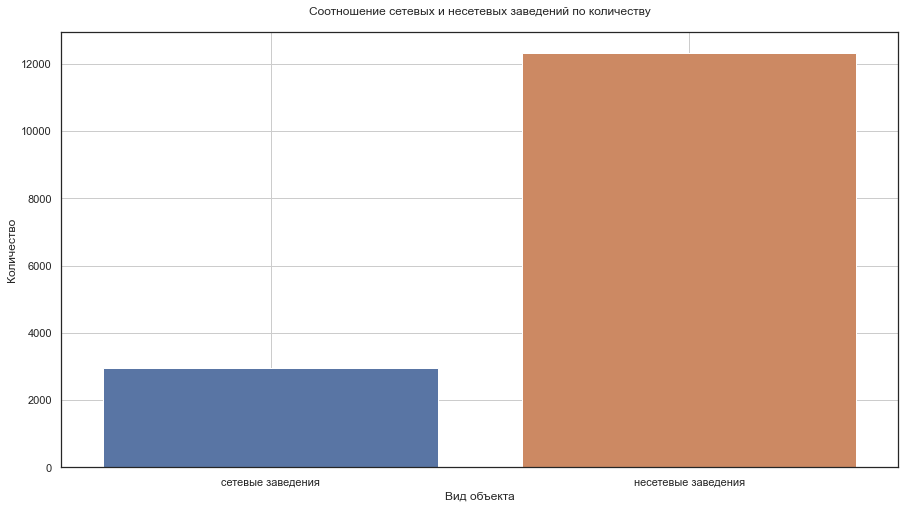

In [17]:
sns.barplot(data=rest_chain_not_chain, x='chain', y='amount')

plt.grid()
plt.title('Соотношение сетевых и несетевых заведений по количеству'+ "\n")
plt.xlabel('Вид объекта')
plt.ylabel('Количество');

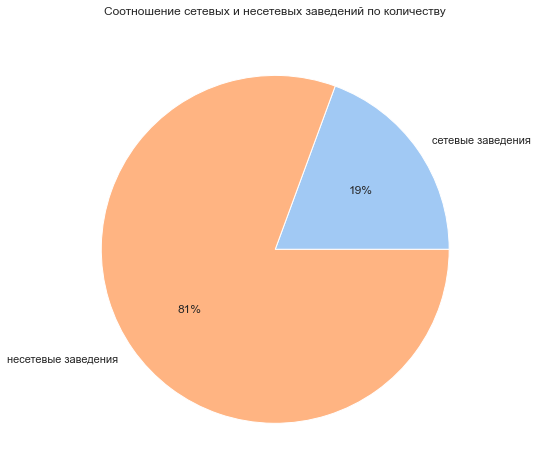

In [18]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(data=rest_chain_not_chain, labels='chain', x='amount', colors = colors, autopct='%.0f%%')
plt.title('Соотношение сетевых и несетевых заведений по количеству'+ "\n");

**Вывод**: Несетевые заведения составляют 81% от общего числа заведений - их 12398. Сетевых же всего 19% - 2968.

<a id='section2-3'></a>
### 2.3 Сетевое распространение различных видов объектов общественного питания

Сгруппируем данные таблицы rest и для каждого типа заведения построим круговую диаграмму с соотношением сетевых и несетевых заведений.

In [19]:
types_chain_not_chain = rest.pivot_table(index='chain', columns='object_type', values='id', aggfunc='count').reset_index()
types_chain_not_chain.loc[0,'chain'] = 'сетевые заведения'
types_chain_not_chain.loc[1,'chain'] = 'несетевые заведения'

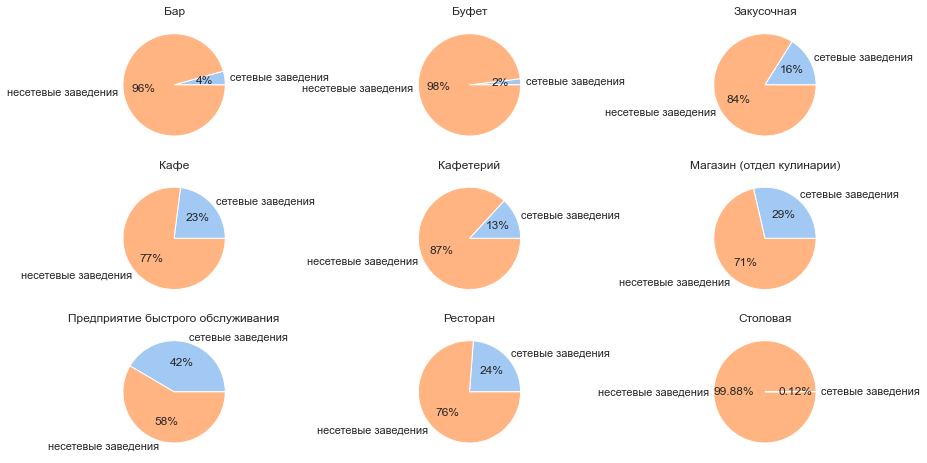

In [20]:
fig = plt.figure()

plt.subplot(3, 3, 1)
plt.pie(data=types_chain_not_chain[['chain','бар']], x='бар', labels='chain', colors = colors, autopct='%.0f%%')
plt.title('Бар')

plt.subplot(3, 3, 2)
plt.pie(data=types_chain_not_chain[['chain','буфет']], x='буфет', labels='chain', colors = colors, autopct='%.0f%%')
plt.title('Буфет')

plt.subplot(3, 3, 3)
plt.pie(data=types_chain_not_chain[['chain','закусочная']], x='закусочная', labels='chain', colors = colors, autopct='%.0f%%')
plt.title('Закусочная')

plt.subplot(3, 3, 4)
plt.pie(data=types_chain_not_chain[['chain','кафе']], x='кафе', labels='chain', colors = colors, autopct='%.0f%%')
plt.title('Кафе')

plt.subplot(3, 3, 5)
plt.pie(data=types_chain_not_chain[['chain','кафетерий']], x='кафетерий', labels='chain', colors = colors, autopct='%.0f%%')
plt.title('Кафетерий')

plt.subplot(3, 3, 6)
plt.pie(data=types_chain_not_chain[['chain','магазин (отдел кулинарии)']], x='магазин (отдел кулинарии)',
        labels='chain', colors = colors, autopct='%.0f%%')
plt.title('Магазин (отдел кулинарии)')

plt.subplot(3, 3, 7)
plt.pie(data=types_chain_not_chain[['chain','предприятие быстрого обслуживания']], x='предприятие быстрого обслуживания',
        labels='chain', colors = colors, autopct='%.0f%%')
plt.title('Предприятие быстрого обслуживания')

plt.subplot(3, 3, 8)
plt.pie(data=types_chain_not_chain[['chain','ресторан']], x='ресторан', labels='chain', colors = colors, autopct='%.0f%%')
plt.title('Ресторан')

plt.subplot(3, 3, 9)
plt.pie(data=types_chain_not_chain[['chain','столовая']], x='столовая', labels='chain', colors = colors, autopct='%.2f%%')
plt.title('Столовая');

**Вывод**: Для всех видов заведений характерно несетевое распространение. Однако, для предприятий быстрого обслуживания наблюдается высокая доля сетевых заведений - 41%, куда, вероятнее всего, входят такие популярные сети,как "макдональдс", "kfc", "burger king" и тд. Следующими по доле сетевых точек идут отделы кулинарии в магазинах - это объяснимо тем, что подобные заведения находятся в сетевых магазинах. 24% ресторанов и 23% кафе также имеют сетевое распространение. Для остальных типов заведений эта доля составляет менее 16%.

<a id='section2-4'></a>
### 2.4 Связь количества посадочных мест с количеством заведений

Выделим в отдельную таблицу медианное количество посадочных мест в разных сетевых заведениях.

In [21]:
rest_number_of_seats = (rest.query('chain == "да"')
                               .groupby(['object_name', 'object_type'])
                               .agg({'id':'count', 'number':'median'})
                               .rename(columns={'id':'amount_of_objects', 'number':'number_of_seats'})
                               .reset_index()
                               .sort_values(by='amount_of_objects', ascending=False))
rest_number_of_seats.head()

,object_name,object_type,amount_of_objects,number_of_seats
589,шоколадница,кафе,178,50.0
51,kfc,предприятие быстрого обслуживания,122,50.0
331,макдоналдс,предприятие быстрого обслуживания,116,80.0
159,бургер кинг,предприятие быстрого обслуживания,106,43.5
524,теремок,предприятие быстрого обслуживания,66,26.5


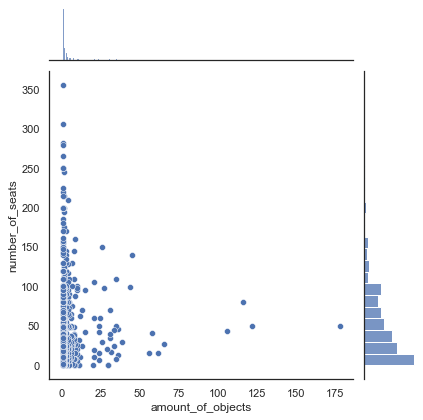

In [22]:
sns.jointplot(x='amount_of_objects', y='number_of_seats', data=rest_number_of_seats) 

Можно видеть, что чем меньше количество заведений в сети, тем больше в них посадочных мест.Для крупных сетей (более 50 объектов) количество посадочных мест находится в пределах 100.

Изучим распределение величин в столбцах с количеством объектов и числом посадочных мест

In [23]:
rest_number_of_seats.describe()

,amount_of_objects,number_of_seats
count,610.000000,610.000000
mean,4.859016,52.860656
std,13.167974,52.457359
min,1.000000,0.000000
25%,1.000000,15.000000
50%,1.000000,40.000000
75%,3.000000,80.000000
max,178.000000,356.000000


Создадим категории для каждого объекта, используя 90-й перцентиль.

In [24]:
def objects_seats_category(objects, seats):
    if (objects > np.percentile(rest_number_of_seats['amount_of_objects'], 90) 
        and seats < np.percentile(rest_number_of_seats['number_of_seats'], 90)):
        return 'много объектов/мало мест'
    
    if (objects > np.percentile(rest_number_of_seats['amount_of_objects'], 90) 
        and seats > np.percentile(rest_number_of_seats['number_of_seats'], 90)):
        return 'много объектов/много мест'
    
    if (objects < np.percentile(rest_number_of_seats['amount_of_objects'], 90) 
        and seats < np.percentile(rest_number_of_seats['number_of_seats'], 90)):
        return 'мало объектов/мало мест'
    
    if (objects < np.percentile(rest_number_of_seats['amount_of_objects'], 90) 
        and seats > np.percentile(rest_number_of_seats['number_of_seats'], 90)):
        return 'мало объектов/много мест'
    
rest_number_of_seats['category'] = rest_number_of_seats.apply(lambda row: objects_seats_category(row['amount_of_objects'],
                                                                                                 row['number_of_seats']), axis=1)

In [25]:
rest_number_of_seats.head()

,object_name,object_type,amount_of_objects,number_of_seats,category
589,шоколадница,кафе,178,50.0,много объектов/мало мест
51,kfc,предприятие быстрого обслуживания,122,50.0,много объектов/мало мест
331,макдоналдс,предприятие быстрого обслуживания,116,80.0,много объектов/мало мест
159,бургер кинг,предприятие быстрого обслуживания,106,43.5,много объектов/мало мест
524,теремок,предприятие быстрого обслуживания,66,26.5,много объектов/мало мест


In [26]:
r = rest_number_of_seats.groupby('category').agg({'category':'count'}).rename(columns={'category':'amount'}).reset_index()

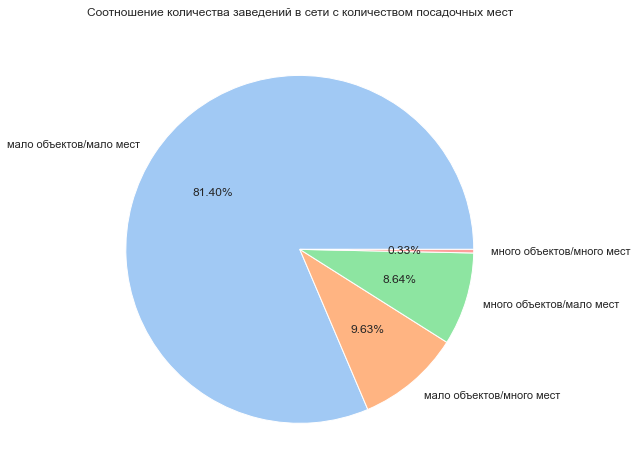

In [27]:
plt.pie(data=r, labels='category', x='amount', colors = colors, autopct='%.2f%%')
plt.title('Соотношение количества заведений в сети с количеством посадочных мест'+ "\n");

Теперь построим график со средним количеством мест в каждой категории

In [28]:
r_1_mean = (rest_number_of_seats.groupby('category')
                           .agg({'amount_of_objects':'mean', 'number_of_seats':'mean'})
                           .round(0)
                           .rename(columns={'amount_of_objects':'mean_amount_of_objects',
                                           'number_of_seats':'mean_number_of_seats'})
                           .reset_index())
r_1_mean

,category,mean_amount_of_objects,mean_number_of_seats
0,мало объектов/мало мест,2.0,40.0
1,мало объектов/много мест,2.0,173.0
2,много объектов/мало мест,34.0,41.0
3,много объектов/много мест,36.0,145.0


In [29]:
r_1_median = (rest_number_of_seats.groupby('category')
                           .agg({'amount_of_objects':'median', 'number_of_seats':'median'})
                           .round(0)
                           .rename(columns={'amount_of_objects':'median_amount_of_objects',
                                           'number_of_seats':'median_number_of_seats'})
                           .reset_index())
r_1_median

,category,median_amount_of_objects,median_number_of_seats
0,мало объектов/мало мест,1.0,35.0
1,мало объектов/много мест,1.0,150.0
2,много объектов/мало мест,26.0,34.0
3,много объектов/много мест,36.0,145.0


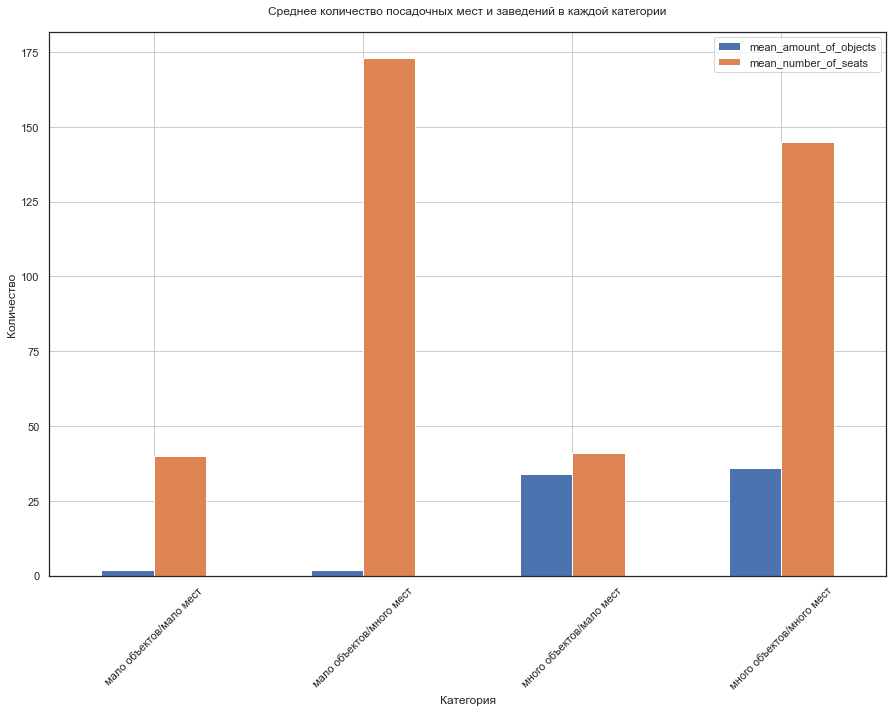

In [30]:
r_1_mean.plot(kind='bar', x='category', y=['mean_amount_of_objects', 'mean_number_of_seats'], grid=True,
               figsize=(15,10), xlabel='Категория', ylabel='Количество',
               title='Среднее количество посадочных мест и заведений в каждой категории\n')
plt.xticks(rotation=45);

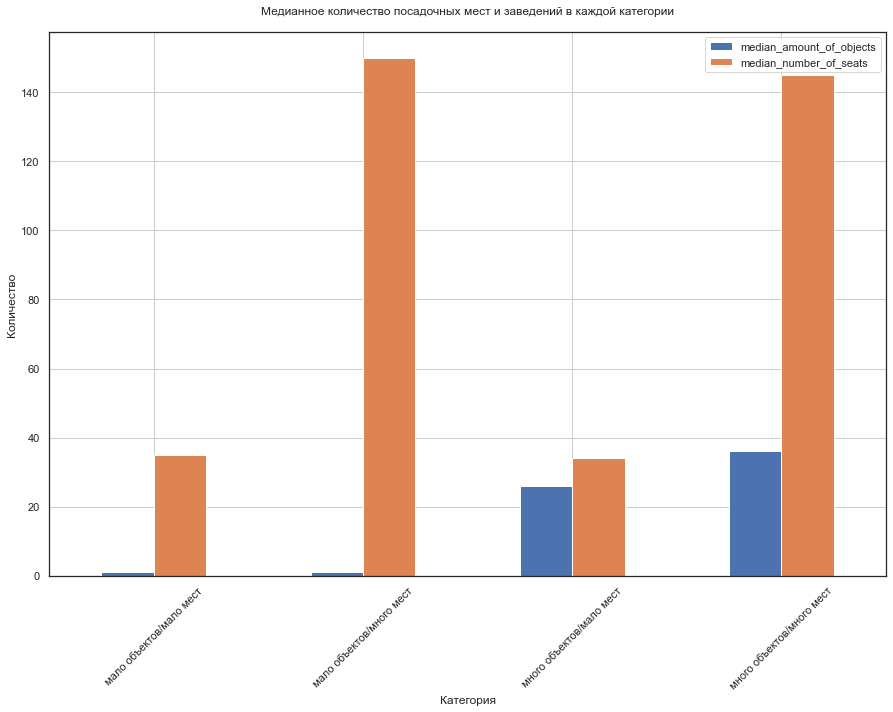

In [31]:
r_1_median.plot(kind='bar', x='category', y=['median_amount_of_objects', 'median_number_of_seats'], grid=True,
               figsize=(15,10), xlabel='Категория', ylabel='Количество',
               title='Медианное количество посадочных мест и заведений в каждой категории\n')
plt.xticks(rotation=45);

**Вывод**: Заведений категории "мало объектов/мало мест" больше всего (81%), в них в среднем 40 посадочных мест (35 - медиана). В категории "мало объектов/много мест" практически 10% всех заведений и в них в среднем 173 места (150 - медиана). В категории "много объектов/мало мест" менее 9% всех заведений и в них в среднем 41 место (34 - медиана). Менее 1% заведений в категории "много объектов/много мест" и там в среднем 145 посадочных мест (145-медиана)

<a id='section2-5'></a>
### 2.5 Среднее количество посадочных мест для различных объектов общественного питания 

В отдельную таблицу соберем среднее количество посадочных мест для каждого типа заведения.

In [32]:
mean_number_of_seats = (rest.groupby('object_type')
                            .agg({'number':'mean'})
                            .rename(columns={'number':'number_of_seats'})
                            .reset_index()
                            .sort_values(by='number_of_seats', ascending=False))

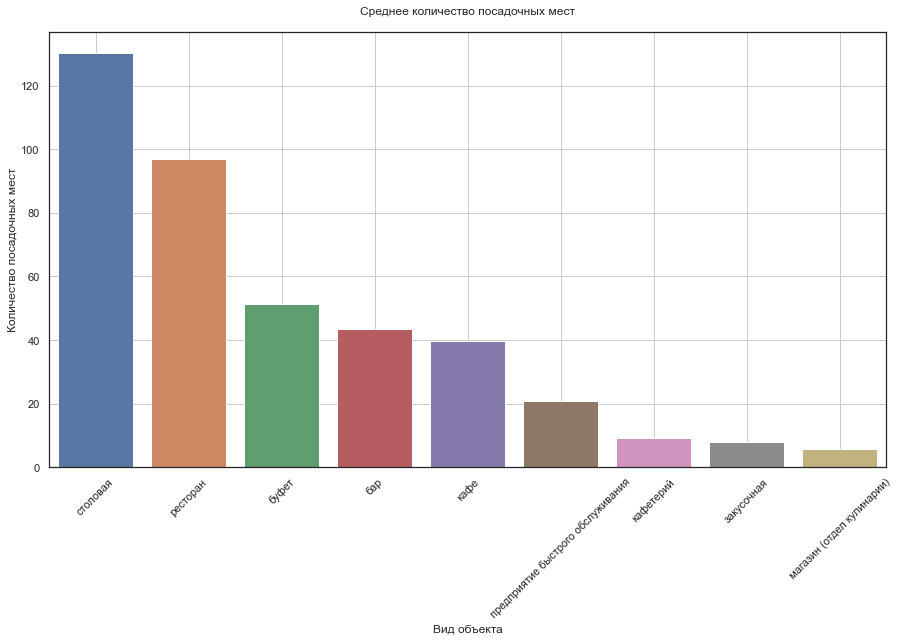

In [33]:
sns.barplot(data=mean_number_of_seats, x='object_type', y='number_of_seats')

plt.grid()
plt.title('Среднее количество посадочных мест'+ "\n")
plt.xlabel('Вид объекта')
plt.ylabel('Количество посадочных мест')
plt.xticks(rotation=45);

**Вывод**: Самое большое количество посадочных мест характерно для столовых (в среднем 130), далее идут рестораны (в среднем 97), буфеты (в среднем 51), бары (в среднем 43), кафе (в среднем 40). Для остальных видов заведений среднее количество посадочных мест менее 20. Меньше всего посадочных мест в отделах кулинарии в магазинах (всего 6).

<a id='section2-6'></a>
### 2.6 Топ-10 улиц Москвы по количеству объектов общественного питания, районы их расположения

Для выделения названия улицы из адреса воспользуемся методом строк split().

In [34]:
rest['street'] = rest['address'].str.split(", ", expand=True)[1]

Создадим таблицу с топ-10 улиц по количеству заведений общепита. В топ-10 улиц ошибочно вошли город Зеленоград и поселение Сосенское. Сразу удалим их из топ-10 улиц и выведем обновленную таблицу.

In [35]:
top_10_streets = (rest.groupby('street')
                      .agg({'id':'count'})
                      .rename(columns={'id':'number_of_objects'})
                      .sort_values(by='number_of_objects', ascending=False)
                      .reset_index()
                      .head(12))
top_10_streets = top_10_streets.drop(index=[0,7]).reset_index(drop=True)
top_10_streets

,street,number_of_objects
0,проспект Мира,203
1,Профсоюзная улица,181
2,Ленинградский проспект,170
3,Пресненская набережная,167
4,Варшавское шоссе,161
5,Ленинский проспект,147
6,проспект Вернадского,128
7,Кутузовский проспект,114
8,Каширское шоссе,111
9,Кировоградская улица,108


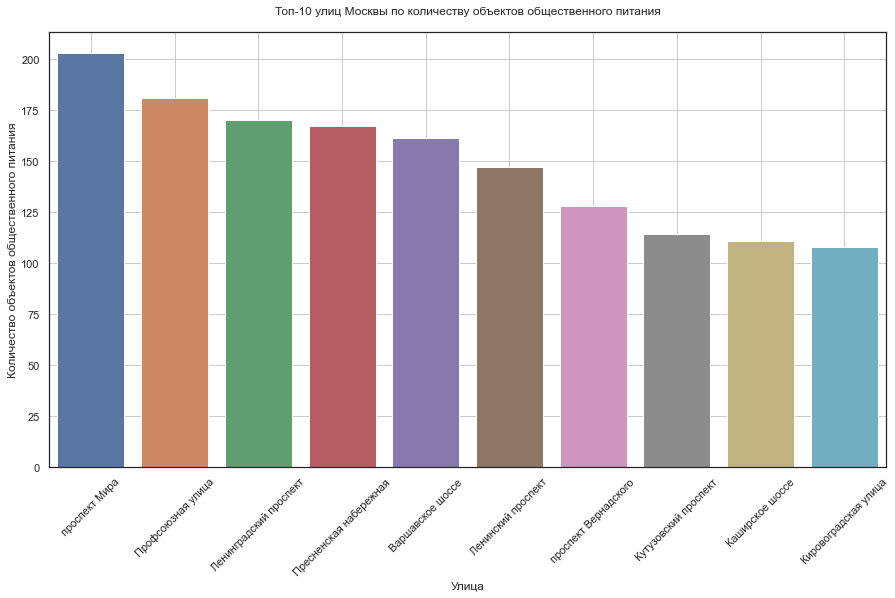

In [36]:
sns.barplot(data=top_10_streets, x='street', y='number_of_objects')

plt.grid()
plt.title('Топ-10 улиц Москвы по количеству объектов общественного питания'+ "\n")
plt.xlabel('Улица')
plt.ylabel('Количество объектов общественного питания')
plt.xticks(rotation=45);

Для определения названия района для топ-10 улиц будем использовать датасет Мосгаза: https://frs.noosphere.ru/xmlui/handle/20.500.11925/714058?show=full

In [38]:
try:
    areas = pd.read_csv('/datasets/mosgaz_streets.csv')

except FileNotFoundError:
    filename = os.path.join(os.sep, os.getcwd(), 'datasets', 'mosgaz_streets.csv')
    areas = pd.read_csv(filename)

In [39]:
areas.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [41]:
areas = areas.rename(columns={'streetname':'street'})

Так как в нашем топ-10 отсутствуют номера домов, то для одной улицы получим несколько названий районов. Эти районы находятся в пределах одного округа, что не внесет искажения в выводы.

In [42]:
top_10_streets_areas = top_10_streets.merge(areas, on='street', how='left')
top_10_streets_areas

,street,number_of_objects,areaid,okrug,area
0,проспект Мира,203,70,СВАО,Алексеевский район
1,проспект Мира,203,86,СВАО,Ярославский Район
2,проспект Мира,203,78,СВАО,Район Марьина роща
3,проспект Мира,203,79,СВАО,Останкинский район
4,проспект Мира,203,81,СВАО,Район Ростокино
5,проспект Мира,203,82,СВАО,Район Свиблово
6,проспект Мира,203,16,ЦАО,Мещанский район
7,Профсоюзная улица,181,123,ЮЗАО,Академический район
8,Профсоюзная улица,181,132,ЮЗАО,Район Черемушки
9,Профсоюзная улица,181,134,ЮЗАО,Район Ясенево


In [43]:
print('Улицы, входящие в топ-10 по количеству объектов общественного питания расположены в следующих районах:',
      list(top_10_streets_areas['area'].unique()))

Улицы, входящие в топ-10 по количеству объектов общественного питания расположены в следующих районах: ['Алексеевский район', 'Ярославский Район', 'Район Марьина роща', 'Останкинский район', 'Район Ростокино', 'Район Свиблово', 'Мещанский район', 'Академический район', 'Район Черемушки', 'Район Ясенево', 'Район Коньково', 'Обручевский район', 'Район Теплый Стан', 'Район Аэропорт', 'Район Беговой', 'Хорошевский район', 'Район Сокол', 'Пресненский район', 'Район Чертаново Центральное', 'Район Чертаново Северное', 'Район Чертаново Южное', 'Донской район', 'Район Нагатино-Садовники', 'Нагорный район', 'Район Северное Бутово', 'Район Южное Бутово', 'Район Проспект Вернадского', 'Район Тропарево-Никулино', 'Район Гагаринский', 'Ломоносовский район', 'Район Якиманка', 'Район Раменки', 'Район Дорогомилово', 'Район Фили-Давыдково', 'Район Москворечье-Сабурово', 'Район Орехово-Борисово Южное', 'Район Орехово-Борисово Северное']


## Часть 3. Вывод

В ходе выполнения работы была проведена предобработка данных и их дальнейший анализ. В частности, в ходе предобработки были устранены неявные дубликаты в данных, а при проведении анализа данных:
 - исследованы соотношение видов объектов общественного питания по количеству и соотношение сетевых и несетевых заведений по количеству,
 - определены виды объектов общественного питания, для которых характерно сетевое распространение, и их особенности в количестве посадочных мест,
 - определены топ-10 улиц и соответствующих им районов по количеству заведений общественного питания.

На основании проведенного анализа можно сделать следующие выводы по открытию кафе, в котором будут работать роботы-официанты:
 - В Москве преобладают заведения типа "кафе". Данный тип заведений пользуется большой популярностью за счет некоторой простоты его посещения (это не дорогущий ресторан с дрескодом, хотя и рестораны бывают разные).
 - Для нашего робо-кафе следует выбрать следующий тип заведения - **несетевое кафе**. Проект и без того дорогой за счет использования роботов, в связи с чем привлекать клиентов стоит его уникальностью, а не шаговой доступностью во всех районах города (то есть вариант сети исключаем).
 - Для нашего несетевого робо-кафе стоит предусмотреть порядка **50 посадочных мест**. Это позволит сделать кафе небольшим, но достаточно вместительным.
 - При составлении рекомендаций по району размещения кафе, будем основываться на том, что чем ближе к центру города будет расположено кафе, тем выше вероятность, что люди будут не лениться приезжать в него с разных концов города. К таким районам отнесем следующие девять: **Мещанский район, Академический район, Район Беговой, Хорошевский район, Пресненский район, Донской район, Район Гагаринский, Район Якиманка, Район Дорогомилово**. *Дополнительно можно отметить, что в районах "ближе к центру" проживают весьма обеспеченные люди, которые могут стать постоянными клиентами*.